In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import array
#from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [2]:
#from keras.datasets import reuters
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from tensorflow.keras.layers import LSTM, GRU

Using TensorFlow backend.


In [3]:
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
aba=pd.read_csv("datasets/total_sjjnj_data.csv",encoding='utf-8')
aa=aba.drop(['Unnamed: 0'],axis=1)
aab=aa.set_index('날짜')
aaaa=aab.fillna(method='ffill') #뒤의 결측치를 앞의값으로 채우기
aabb2=aaaa.drop(['2021-02-01','2021-02-02','2021-02-03']) #2021년자료 3개라 삭제함
aabb3=aabb2[['소갈비평균','소갈비최고가','소갈비최저']]
c=aabb3.dropna()
b=c.values.astype('float')
c

,소갈비평균,소갈비최고가,소갈비최저
날짜,,,
2011-01-03,6925.0,7000.0,6850.0
2011-01-04,6925.0,7000.0,6850.0
2011-01-05,6925.0,7000.0,6850.0
2011-01-06,6925.0,7000.0,6850.0
2011-01-07,6925.0,7000.0,6850.0
...,...,...,...
2021-12-27,6606.0,8980.0,5330.0
2021-12-28,6606.0,8980.0,5330.0
2021-12-29,6606.0,8980.0,5330.0


In [5]:
n=b.shape[0]
time_steps=5
number_of_data=n-time_steps
train_rate=0.8
number_of_train=(n-time_steps)*train_rate

In [6]:
number_of_train+time_steps

2097.0

In [7]:
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
ss.fit(b[:int(number_of_train+time_steps)])
dataset=ss.transform(b)
dataset.shape

(2620, 3)

In [8]:
def split_xy(dataset,target,time_steps, y_column):
    x,y=[],[]
    for i in range(len(dataset)):
        x_end_number=i+time_steps
        y_end_number=(x_end_number+1)+y_column
        if y_end_number>len(dataset):
            break
        tmp_x=dataset[i:x_end_number,:]
        tmp_y=target[x_end_number+1:y_end_number,0] #네네 2011~1월1일~2020-1월7일개 2021 1월1일 1월7
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x),np.array(y)

In [9]:
x,y=split_xy(dataset,b,time_steps,1)
x.shape, y.shape

((2614, 5, 3), (2614, 1))

In [10]:
train_input=x[0:int(number_of_train)]
train_target=y[0:int(number_of_train)]
test_input=x[int(number_of_train):]
test_target=y[int(number_of_train):]

In [11]:
train_input.shape, train_target.shape,test_input.shape, test_target.shape

((2092, 5, 3), (2092, 1), (522, 5, 3), (522, 1))

In [12]:
model=Sequential()
model.add(GRU(64, input_shape=(5,3), return_sequences=True))
model.add(GRU(32))
model.add(Dense(16, activation="relu"))
#model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [13]:

#모델 저장 폴더 설정
dir_name="layer_{0}_node{1}_{2}_{3}".format(3,64,32,16)
MODEL_DIR=f'./model_{dir_name}/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
#모델 저장 조건 설정
modelpath=MODEL_DIR+"{epoch:02d}-{val_loss:.4f}.hdf5"

#모델 업데이트 및 저장
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
#학습 자동 중단 설정
early_stopping_callback=EarlyStopping(monitor='val_loss', patience=20)

# 모델 실행 및 저장
history=model.fit(train_input, train_target, validation_split=0.2, epochs=200, batch_size=30, verbose=1, callbacks=[early_stopping_callback,checkpointer])
#model.fit(validation_data=(train_input, train_target), validation_split=0.2, epochs=200, batch_size=200, verbose=0, callbacks=[checkpointer])

Epoch 1/200
56/56 [==============================] - 4s 36ms/step - loss: 22150165.2632 - mae: 4677.3464 - val_loss: 27610044.0000 - val_mae: 5251.8354

Epoch 00001: val_loss improved from inf to 27610044.00000, saving model to ./model_layer_3_node64_32_16\01-27610044.0000.hdf5
Epoch 2/200
56/56 [==============================] - 0s 3ms/step - loss: 21728723.1228 - mae: 4634.6179 - val_loss: 27516084.0000 - val_mae: 5242.8853

Epoch 00002: val_loss improved from 27610044.00000 to 27516084.00000, saving model to ./model_layer_3_node64_32_16\02-27516084.0000.hdf5
Epoch 3/200
56/56 [==============================] - 0s 3ms/step - loss: 21977526.3860 - mae: 4658.6967 - val_loss: 27451514.0000 - val_mae: 5236.7256

Epoch 00003: val_loss improved from 27516084.00000 to 27451514.00000, saving model to ./model_layer_3_node64_32_16\03-27451514.0000.hdf5
Epoch 4/200
56/56 [==============================] - 0s 3ms/step - loss: 21719676.8421 - mae: 4631.9886 - val_loss: 27374116.0000 - val_mae: 52

56/56 [==============================] - 0s 3ms/step - loss: 17093292.2982 - mae: 4096.1230 - val_loss: 21430188.0000 - val_mae: 4626.2251

Epoch 00029: val_loss improved from 21774446.00000 to 21430188.00000, saving model to ./model_layer_3_node64_32_16\29-21430188.0000.hdf5
Epoch 30/200
56/56 [==============================] - 0s 3ms/step - loss: 16542363.4737 - mae: 4030.0989 - val_loss: 21081604.0000 - val_mae: 4588.3940

Epoch 00030: val_loss improved from 21430188.00000 to 21081604.00000, saving model to ./model_layer_3_node64_32_16\30-21081604.0000.hdf5
Epoch 31/200
56/56 [==============================] - 0s 3ms/step - loss: 16265929.9298 - mae: 3997.3610 - val_loss: 20728274.0000 - val_mae: 4549.7295

Epoch 00031: val_loss improved from 21081604.00000 to 20728274.00000, saving model to ./model_layer_3_node64_32_16\31-20728274.0000.hdf5
Epoch 32/200
56/56 [==============================] - 0s 3ms/step - loss: 15936615.4035 - mae: 3954.1228 - val_loss: 20370604.0000 - val_mae: 4

56/56 [==============================] - 0s 3ms/step - loss: 7977609.0263 - mae: 2778.2335 - val_loss: 11139484.0000 - val_mae: 3333.3538

Epoch 00057: val_loss improved from 11488863.00000 to 11139484.00000, saving model to ./model_layer_3_node64_32_16\57-11139484.0000.hdf5
Epoch 58/200
56/56 [==============================] - 0s 3ms/step - loss: 7697300.4912 - mae: 2724.8237 - val_loss: 10794292.0000 - val_mae: 3281.1670

Epoch 00058: val_loss improved from 11139484.00000 to 10794292.00000, saving model to ./model_layer_3_node64_32_16\58-10794292.0000.hdf5
Epoch 59/200
56/56 [==============================] - 0s 3ms/step - loss: 7505893.5789 - mae: 2688.7944 - val_loss: 10453175.0000 - val_mae: 3228.7673

Epoch 00059: val_loss improved from 10794292.00000 to 10453175.00000, saving model to ./model_layer_3_node64_32_16\59-10453175.0000.hdf5
Epoch 60/200
56/56 [==============================] - 0s 3ms/step - loss: 7111245.5965 - mae: 2617.4281 - val_loss: 10116815.0000 - val_mae: 3176.

56/56 [==============================] - 0s 4ms/step - loss: 1953431.2368 - mae: 1289.6895 - val_loss: 3357781.0000 - val_mae: 1824.7045

Epoch 00086: val_loss improved from 3537128.75000 to 3357781.00000, saving model to ./model_layer_3_node64_32_16\86-3357781.0000.hdf5
Epoch 87/200
56/56 [==============================] - 0s 4ms/step - loss: 1775658.8443 - mae: 1219.5594 - val_loss: 3185833.5000 - val_mae: 1776.9630

Epoch 00087: val_loss improved from 3357781.00000 to 3185833.50000, saving model to ./model_layer_3_node64_32_16\87-3185833.5000.hdf5
Epoch 88/200
56/56 [==============================] - 0s 4ms/step - loss: 1664343.5000 - mae: 1180.1231 - val_loss: 3019400.7500 - val_mae: 1729.4988

Epoch 00088: val_loss improved from 3185833.50000 to 3019400.75000, saving model to ./model_layer_3_node64_32_16\88-3019400.7500.hdf5
Epoch 89/200
56/56 [==============================] - 0s 4ms/step - loss: 1507320.9803 - mae: 1123.9419 - val_loss: 2860452.2500 - val_mae: 1682.9192

Epoch 0

56/56 [==============================] - 0s 4ms/step - loss: 331344.9013 - mae: 399.7493 - val_loss: 660362.3750 - val_mae: 795.0638

Epoch 00115: val_loss improved from 692743.25000 to 660362.37500, saving model to ./model_layer_3_node64_32_16\115-660362.3750.hdf5
Epoch 116/200
56/56 [==============================] - 0s 4ms/step - loss: 327365.5170 - mae: 397.6432 - val_loss: 631070.3750 - val_mae: 776.4242

Epoch 00116: val_loss improved from 660362.37500 to 631070.37500, saving model to ./model_layer_3_node64_32_16\116-631070.3750.hdf5
Epoch 117/200
56/56 [==============================] - 0s 4ms/step - loss: 364400.9836 - mae: 420.0826 - val_loss: 603271.2500 - val_mae: 758.3110

Epoch 00117: val_loss improved from 631070.37500 to 603271.25000, saving model to ./model_layer_3_node64_32_16\117-603271.2500.hdf5
Epoch 118/200
56/56 [==============================] - 0s 3ms/step - loss: 345723.0428 - mae: 410.7650 - val_loss: 579243.9375 - val_mae: 742.2992

Epoch 00118: val_loss impr

56/56 [==============================] - 0s 3ms/step - loss: 139707.1035 - mae: 178.9795 - val_loss: 160923.0781 - val_mae: 363.6915

Epoch 00144: val_loss improved from 179191.50000 to 160923.07812, saving model to ./model_layer_3_node64_32_16\144-160923.0781.hdf5
Epoch 145/200
56/56 [==============================] - 0s 3ms/step - loss: 140427.4538 - mae: 168.7926 - val_loss: 145893.9531 - val_mae: 342.3827

Epoch 00145: val_loss improved from 160923.07812 to 145893.95312, saving model to ./model_layer_3_node64_32_16\145-145893.9531.hdf5
Epoch 146/200
56/56 [==============================] - 0s 3ms/step - loss: 114118.0965 - mae: 149.8926 - val_loss: 133403.1562 - val_mae: 323.5722

Epoch 00146: val_loss improved from 145893.95312 to 133403.15625, saving model to ./model_layer_3_node64_32_16\146-133403.1562.hdf5
Epoch 147/200
56/56 [==============================] - 0s 3ms/step - loss: 114229.1074 - mae: 150.5826 - val_loss: 121463.1016 - val_mae: 304.7722

Epoch 00147: val_loss impr

56/56 [==============================] - 0s 3ms/step - loss: 69578.9067 - mae: 91.4841 - val_loss: 24429.1699 - val_mae: 86.5220

Epoch 00174: val_loss improved from 26424.14258 to 24429.16992, saving model to ./model_layer_3_node64_32_16\174-24429.1699.hdf5
Epoch 175/200
56/56 [==============================] - 0s 3ms/step - loss: 76650.5290 - mae: 98.8853 - val_loss: 21806.7402 - val_mae: 82.4686

Epoch 00175: val_loss improved from 24429.16992 to 21806.74023, saving model to ./model_layer_3_node64_32_16\175-21806.7402.hdf5
Epoch 176/200
56/56 [==============================] - 0s 3ms/step - loss: 66072.7299 - mae: 92.6276 - val_loss: 20247.8672 - val_mae: 76.1921

Epoch 00176: val_loss improved from 21806.74023 to 20247.86719, saving model to ./model_layer_3_node64_32_16\176-20247.8672.hdf5
Epoch 177/200
56/56 [==============================] - 0s 3ms/step - loss: 67474.0985 - mae: 96.4193 - val_loss: 18666.4824 - val_mae: 78.7929

Epoch 00177: val_loss improved from 20247.86719 to 

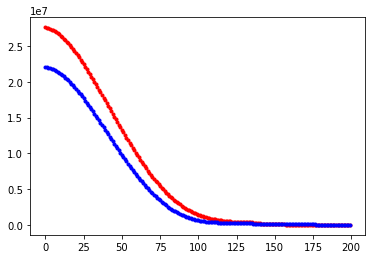

In [17]:
y_vloss = history.history['val_loss'] #과적합발생여뷰 빨강검즈용 로스
y_loss = history.history['loss'] #훈련셋 로스
y_acc = history.history['mae']

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c = "red", markersize = 3)
plt.plot(x_len, y_loss, "o", c = "blue", markersize = 3)
#plt.ylim()
#plt.ylim(0.00,1000000)

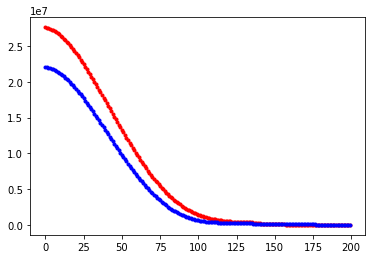

In [18]:
y_vloss = history.history['val_loss'] #과적합발생여뷰 빨강검즈용 로스
y_loss = history.history['loss'] #훈련셋 로스
y_acc = history.history['mae']

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c = "red", markersize = 3)
plt.plot(x_len, y_loss, "o", c = "blue", markersize = 3)
#plt.ylim()

In [19]:
abd

NameError: name 'abd' is not defined

In [20]:
abd=model.predict(x)#교차검증해보기
abd.shape

(2614, 1)

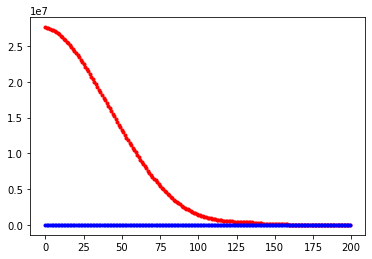

In [21]:
y_vloss = history.history['val_loss']
y_acc = history.history['mae']

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c = "red", markersize = 3)
plt.plot(x_len, y_acc, "o", c = "blue", markersize = 3)
plt.show()

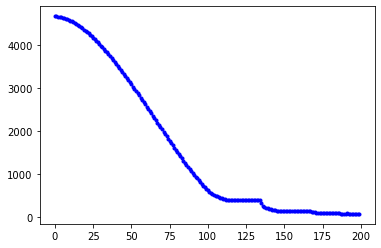

In [22]:
plt.plot(x_len, y_acc, "o", c = "blue", markersize = 3)

In [23]:
model.evaluate(test_input,test_target) #과적합인거같음

17/17 [==============================] - 0s 810us/step - loss: 289190.3125 - mae: 424.5004


[289190.3125, 424.5003967285156]

In [24]:
x.shape

(2614, 5, 3)

In [25]:
from tensorflow.keras.models import load_model
loaded_model=load_model(MODEL_DIR+"139-11240.8867.hdf5")

OSError: SavedModel file does not exist at: ./model_layer_3_node64_32_16/139-11240.8867.hdf5/{saved_model.pbtxt|saved_model.pb}

In [26]:
loaded_model.evaluate(test_input, test_target)


NameError: name 'loaded_model' is not defined

In [27]:
#model.predict(test_input)

In [28]:
a=c
aaaaa=a.reset_index('날짜')
aaaaa

,날짜,소갈비평균,소갈비최고가,소갈비최저
0,2011-01-03,6925.0,7000.0,6850.0
1,2011-01-04,6925.0,7000.0,6850.0
2,2011-01-05,6925.0,7000.0,6850.0
3,2011-01-06,6925.0,7000.0,6850.0
4,2011-01-07,6925.0,7000.0,6850.0
...,...,...,...,...
2615,2021-12-27,6606.0,8980.0,5330.0
2616,2021-12-28,6606.0,8980.0,5330.0
2617,2021-12-29,6606.0,8980.0,5330.0
2618,2021-12-30,6606.0,8980.0,5330.0


In [29]:
a1=aaaaa.drop(index=0)
a2=a1.drop(index=1)
a3=a2.drop(index=2)
a4=a3.drop(index=3)
a5=a4.drop(index=4)
a7=a5.drop(index=5)
a7

,날짜,소갈비평균,소갈비최고가,소갈비최저
6,2011-01-11,6925.0,7000.0,6850.0
7,2011-01-12,6925.0,7000.0,6850.0
8,2011-01-13,6925.0,7000.0,6850.0
9,2011-01-14,6925.0,7000.0,6850.0
10,2011-01-18,6925.0,7000.0,6850.0
...,...,...,...,...
2615,2021-12-27,6606.0,8980.0,5330.0
2616,2021-12-28,6606.0,8980.0,5330.0
2617,2021-12-29,6606.0,8980.0,5330.0
2618,2021-12-30,6606.0,8980.0,5330.0


In [30]:
a8=a7.set_index('날짜')
a8
a9=a8.reset_index('날짜')
a9
a9['날짜']=pd.to_datetime(a9['날짜'])
a9

,날짜,소갈비평균,소갈비최고가,소갈비최저
0,2011-01-11,6925.0,7000.0,6850.0
1,2011-01-12,6925.0,7000.0,6850.0
2,2011-01-13,6925.0,7000.0,6850.0
3,2011-01-14,6925.0,7000.0,6850.0
4,2011-01-18,6925.0,7000.0,6850.0
...,...,...,...,...
2609,2021-12-27,6606.0,8980.0,5330.0
2610,2021-12-28,6606.0,8980.0,5330.0
2611,2021-12-29,6606.0,8980.0,5330.0
2612,2021-12-30,6606.0,8980.0,5330.0


In [31]:
aaa=pd.DataFrame(y,columns=['target'])
abd=pd.DataFrame(abd,columns=['predict'])

<AxesSubplot:>

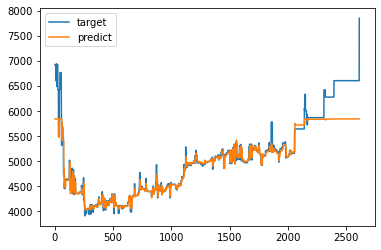

In [32]:
c5=pd.concat([a9,aaa],axis=1)
c5
c6=pd.concat([c5,abd],axis=1)
c6[['target','predict']].plot() #matplotlib x를 데이트타임으로잡고하자
#프레딕트를 모델프레딕트한것을 열에추가해서 그래프그리기
#테스트셋한거와 테스트프레딕트한것을 색깔다르게


In [33]:
c6

,날짜,소갈비평균,소갈비최고가,소갈비최저,target,predict
0,2011-01-11,6925.0,7000.0,6850.0,6925.0,5845.246582
1,2011-01-12,6925.0,7000.0,6850.0,6925.0,5845.246582
2,2011-01-13,6925.0,7000.0,6850.0,6925.0,5845.246582
3,2011-01-14,6925.0,7000.0,6850.0,6925.0,5845.246582
4,2011-01-18,6925.0,7000.0,6850.0,6925.0,5845.246582
...,...,...,...,...,...,...
2609,2021-12-27,6606.0,8980.0,5330.0,6606.0,5843.903809
2610,2021-12-28,6606.0,8980.0,5330.0,6606.0,5843.903809
2611,2021-12-29,6606.0,8980.0,5330.0,6606.0,5843.903809
2612,2021-12-30,6606.0,8980.0,5330.0,6606.0,5843.903809


In [34]:
c666=c6[['target','predict']]
c666

,target,predict
0,6925.0,5845.246582
1,6925.0,5845.246582
2,6925.0,5845.246582
3,6925.0,5845.246582
4,6925.0,5845.246582
...,...,...
2609,6606.0,5843.903809
2610,6606.0,5843.903809
2611,6606.0,5843.903809
2612,6606.0,5843.903809


In [51]:
c6['YEARMONTH'] = c6['날짜'].dt.strftime('%Y%m')
c6

,날짜,소갈비평균,소갈비최고가,소갈비최저,target,predict,YEARMONTH
0,2011-01-11,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
1,2011-01-12,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
2,2011-01-13,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
3,2011-01-14,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
4,2011-01-18,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
...,...,...,...,...,...,...,...
2609,2021-12-27,6606.0,8980.0,5330.0,6606.0,5843.903809,202112
2610,2021-12-28,6606.0,8980.0,5330.0,6606.0,5843.903809,202112
2611,2021-12-29,6606.0,8980.0,5330.0,6606.0,5843.903809,202112
2612,2021-12-30,6606.0,8980.0,5330.0,6606.0,5843.903809,202112


In [45]:
c111=c6[['YEARMONTH','target','predict']]

In [46]:
c222=c111[c111['YEARMONTH'].str.contains('2011')]

In [47]:
c333=c222.groupby(['YEARMONTH'],as_index=True).mean()
c333

,target,predict
YEARMONTH,,
201101,6879.857143,5845.211914
201102,6695.812500,5844.778320
201103,6267.409091,5794.579590
201104,5766.800000,5639.696777
201105,4690.105263,4787.382324
201106,4642.000000,4611.931152
201107,4716.250000,4691.765137
201108,4649.227273,4579.365234
201109,4623.052632,4586.652344


C:\Users\owner\anaconda3\envs\tf24\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\anaconda3\envs\tf24\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\anaconda3\envs\tf24\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\anaconda3\envs\tf24\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\anaconda3\envs\tf24\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.pri

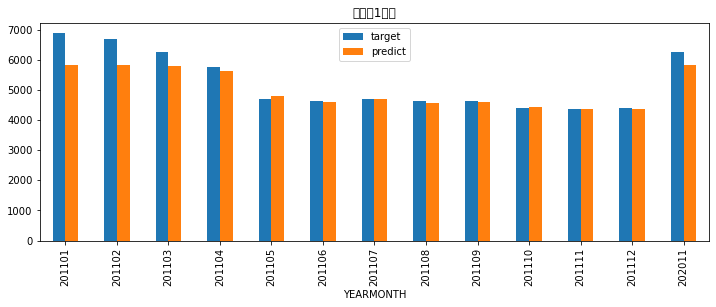

In [48]:
ax2=c333.plot(kind='bar',title='소갈비1등급',figsize=(12,4))

plt.show()

In [55]:
c999['YEARMONTH'] = c999['Year'].dt.strftime('%Y%m')
c999

NameError: name 'c999' is not defined

In [ ]:
c1000=c999.drop(['Year'],axis=1) #2011년도임
c1000

In [ ]:
ax=c1000.plot(kind='bar',title='소갈비1등급',figsize=(12,4))

plt.show()

In [ ]:
c55=c6[['Year','target','predict']]

In [44]:
c66=c55.groupby(['Year'],as_index=True).mean()
c66

NameError: name 'c55' is not defined

In [41]:

ax=c66.plot(kind='bar',title='소갈비1등급',figsize=(12,4))
ax.set_xlabel('연도')
ax.set_ylabel('가격')
ax.legend(['target','predict'])
plt.show()

NameError: name 'c66' is not defined

In [42]:
c7=c6.set_index('날짜')
c7

,소갈비평균,소갈비최고가,소갈비최저,target,predict,YEARMONTH
날짜,,,,,,
2011-01-11,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
2011-01-12,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
2011-01-13,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
2011-01-14,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
2011-01-18,6925.0,7000.0,6850.0,6925.0,5845.246582,201101
...,...,...,...,...,...,...
2021-12-27,6606.0,8980.0,5330.0,6606.0,5843.903809,202112
2021-12-28,6606.0,8980.0,5330.0,6606.0,5843.903809,202112
2021-12-29,6606.0,8980.0,5330.0,6606.0,5843.903809,202112


In [43]:
c8=c7[['target','predict']]

In [ ]:
a7

In [ ]:
abc

In [ ]:
y.shape

In [ ]:
##a6.insert(4,'predict8',y)
#a6.info()

In [ ]:
yy=x.reshape(-1,1)
xx

In [ ]:
xx=x.reshape(-1,1)
xx
#5,3

In [ ]:
xx=xxx.values.astype('float')

In [ ]:
xxx=x.reshape(-1,1)